In [2]:
!pip install tensorflow

In [61]:
import tensorflow as tf
from PIL import Image
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pandas as pd
import numpy as np
import itertools
import base64
import io

In [22]:
attire=['jeans','saree','trousers']

In [23]:
args={'labels':'inferred', 'label_mode':'categorical','batch_size':32,'image_size':(256,256), 'seed':1,'validation_split':0.2,'class_names':attire}

In [24]:
train_data=tf.keras.utils.image_dataset_from_directory("img_classifier",subset='training',**args)

Found 1249 files belonging to 3 classes.
Using 1000 files for training.


In [25]:
test_data=tf.keras.utils.image_dataset_from_directory("img_classifier",subset='validation',**args)

Found 1249 files belonging to 3 classes.
Using 249 files for validation.


In [26]:
first=train_data.take(1) #takes the first batch of 32 images 
first

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [27]:
img,label =list(first)[0]  #getting the image and label from the first batch fetched above

In [28]:
first_img=img[0]     #getting the first image 
first_img

<tf.Tensor: shape=(256, 256, 3), dtype=float32, numpy=
array([[[255.     , 255.     , 255.     ],
        [255.     , 255.     , 255.     ],
        [255.     , 255.     , 255.     ],
        ...,
        [255.     , 255.     , 255.     ],
        [255.     , 255.     , 255.     ],
        [255.     , 255.     , 255.     ]],

       [[255.     , 255.     , 255.     ],
        [255.     , 255.     , 255.     ],
        [255.     , 255.     , 255.     ],
        ...,
        [255.     , 255.     , 255.     ],
        [255.     , 255.     , 255.     ],
        [255.     , 255.     , 255.     ]],

       [[255.     , 255.     , 255.     ],
        [255.     , 255.     , 255.     ],
        [255.     , 255.     , 255.     ],
        ...,
        [255.     , 255.     , 255.     ],
        [255.     , 255.     , 255.     ],
        [255.     , 255.     , 255.     ]],

       ...,

       [[253.875  , 255.     , 248.5    ],
        [253.875  , 255.     , 248.83203],
        [253.875  , 255.   

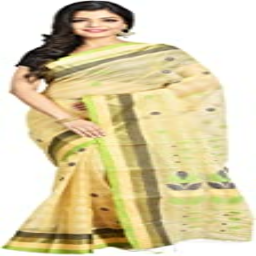

In [29]:
Image.fromarray(first_img.numpy().astype("uint8")) #converting numpy array back to an image

In [30]:
label[0]

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0., 1., 0.], dtype=float32)>

In [32]:
# prefetching the image from hard disk to cache for faster processing
train_data=train_data.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_data=test_data.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [34]:
#Creating neural network
model=Sequential([
    layers.Rescaling(1.0/255),             #rescaling each pixel of the image to the range 0 to 1.
    layers.Conv2D(16,3,padding='same',activation='relu',input_shape=(256,256,3)),       #using Conv2D we are creating a convolution layer for feature extraction from the image, here we are applying filter 16 times and creating a window of 3 pixels
    layers.Flatten(),                      #converting the convolution output containing many layers into one
    layers.Dense(128,activation='relu'),   #generating dense layer after convolution layer
    layers.Dense(len(attire))              #generating prediction layer
])

In [35]:
#compiling the model
model.compile(optimizer='adam',
             loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),     #for reducing wrong predictions
             metrics=['accuracy']
             )

In [36]:
#fitting the model
history=model.fit(train_data,                      #training data
                  validation_data=test_data,       #for validation we use test data
                  epochs=5,                        #number of times model will be trained
                  verbose=1                        #specifying how much output we will get from the model
                 )

Epoch 1/5
32/32 [==============================] - 28s 733ms/step - loss: 131.2925 - accuracy: 0.5030 - val_loss: 4.4211 - val_accuracy: 0.7912
Epoch 2/5
32/32 [==============================] - 23s 719ms/step - loss: 4.6430 - accuracy: 0.7920 - val_loss: 1.6158 - val_accuracy: 0.8233
Epoch 3/5
32/32 [==============================] - 22s 703ms/step - loss: 2.9251 - accuracy: 0.8090 - val_loss: 1.0033 - val_accuracy: 0.8916
Epoch 4/5
32/32 [==============================] - 23s 709ms/step - loss: 1.2165 - accuracy: 0.8980 - val_loss: 1.4048 - val_accuracy: 0.8554
Epoch 5/5
32/32 [==============================] - 23s 705ms/step - loss: 0.6857 - accuracy: 0.9190 - val_loss: 3.5934 - val_accuracy: 0.7309


We could notice validation accuracy after 5 epoch is 0.739 or 73%.

In [37]:
#Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 flatten (Flatten)           (None, 1048576)           0         
                                                                 
 dense (Dense)               (None, 128)               134217856 
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 134,218,691
Trainable params: 134,218,691
Non-trainable params: 0
_________________________________________________________________


# Analysing Model Performance

In [39]:
#Analysing the performance of the model by comparing train and validation accuracy and then plotting it
df=pd.DataFrame.from_dict(history.history)
df[['accuracy','val_accuracy']]

,accuracy,val_accuracy
0,0.503,0.791165
1,0.792,0.823293
2,0.809,0.891566
3,0.898,0.855422
4,0.919,0.730924


<AxesSubplot:>

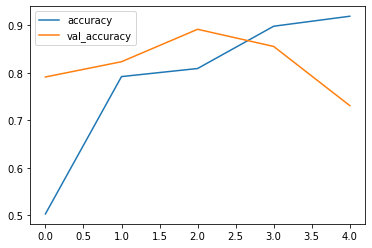

In [40]:
#Plotting the graph for the same for better understanding
df[['accuracy','val_accuracy']].plot()

From the graph above we could observe that the model is overfitting as the difference between accuracy and val_accuracy is higher in the last epoch so we would try to overcome this problem by changing few layes in our model.

In [41]:
def train_model(network,epochs=5):
    model=Sequential(network)
    
    model.compile(optimizer='adam',
             loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),     #for reducing wrong predictions
             metrics=['accuracy']
             )
    
    history=model.fit(train_data,                      #training data
                  validation_data=test_data,       #for validation we use test data
                  epochs=5,                        #number of times model will be trained
                  verbose=1                        #specifying how much output we will get from the model
                 )
    
    df=pd.DataFrame.from_dict(history.history)
    return df,model

In [42]:
network=[layers.Rescaling(1.0/255),             #rescaling each pixel of the image to the range 0 to 1.
    layers.Conv2D(16,3,padding='same',activation='relu',input_shape=(256,256,3)),       #using Conv2D we are creating a convolution layer for feature extraction from the image, here we are applying filter 16 times and creating a window of 3 pixels
    layers.MaxPooling2D(),                 #reduces the number of parameters
    layers.Conv2D(32,3,padding='same',activation='relu',input_shape=(256,256,3)),
    layers.MaxPooling2D(),     
    layers.Conv2D(64,3,padding='same',activation='relu',input_shape=(256,256,3)), 
    layers.MaxPooling2D(),
    layers.Flatten(),                      #converting the convolution output containing many layers into one
    layers.Dense(128,activation='relu'),   #generating dense layer after convolution layer
    layers.Dense(len(attire))]
df,model=train_model(network)

Epoch 1/5
32/32 [==============================] - 19s 554ms/step - loss: 0.8806 - accuracy: 0.6380 - val_loss: 0.3960 - val_accuracy: 0.8474
Epoch 2/5
32/32 [==============================] - 17s 527ms/step - loss: 0.3280 - accuracy: 0.8710 - val_loss: 0.2751 - val_accuracy: 0.8956
Epoch 3/5
32/32 [==============================] - 17s 532ms/step - loss: 0.2274 - accuracy: 0.9160 - val_loss: 0.2512 - val_accuracy: 0.8996
Epoch 4/5
32/32 [==============================] - 17s 535ms/step - loss: 0.1337 - accuracy: 0.9530 - val_loss: 0.2621 - val_accuracy: 0.8956
Epoch 5/5
32/32 [==============================] - 17s 536ms/step - loss: 0.0772 - accuracy: 0.9750 - val_loss: 0.2628 - val_accuracy: 0.9197


<AxesSubplot:>

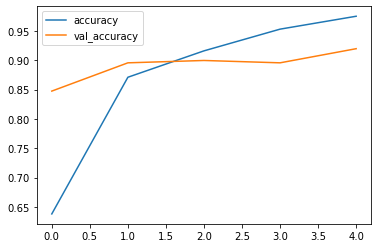

In [43]:
df[['accuracy','val_accuracy']].plot()

Now model seems perfect with val_accuracy = 0.9197

In [44]:
pred=model.predict(test_data)

8/8 [==============================] - 4s 127ms/step


In [46]:
pred_class=np.argmax(pred,axis=1)

In [47]:
pred_class

array([1, 0, 2, 0, 2, 1, 1, 1, 1, 0, 2, 1, 2, 2, 1, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 2, 1, 1, 0, 0, 2, 0, 2, 2, 0, 1, 2, 1, 0, 2, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 0, 2, 0, 0, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 2, 0, 1, 1, 1, 2, 0, 0, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2,
       0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 1, 1, 0, 2,
       2, 1, 0, 1, 0, 2, 2, 2, 1, 1, 2, 2, 0, 1, 1, 2, 0, 1, 0, 2, 1, 0,
       1, 1, 1, 0, 2, 2, 2, 1, 1, 0, 2, 2, 1, 1, 1, 0, 1, 2, 2, 2, 0, 1,
       1, 0, 1, 2, 0, 0, 2, 2, 1, 0, 1, 2, 2, 0, 2, 0, 2, 2, 2, 2, 0, 2,
       0, 0, 2, 1, 2, 1, 1, 1, 1, 1, 0, 2, 0, 2, 2, 2, 1, 2, 1, 2, 0, 0,
       2, 0, 0, 0, 2, 2, 1, 1, 1, 1, 1, 0, 0, 2, 1, 1, 2, 2, 1, 2, 2, 2,
       1, 2, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 0, 1, 2, 1, 0, 1, 0, 1, 2,
       1, 2, 0, 1, 2, 2, 2], dtype=int64)

In [56]:
actual_class=np.concatenate([y for x,y in test_data],axis=0)

In [57]:
actual_class=np.argmax(actual_class,axis=1)

In [52]:
actual_img=[x.numpy().astype("uint8") for x,y in test_data]
actual_img=list(itertools.chain.from_iterable(actual_img))

In [53]:
actual_img=[Image.fromarray(i) for i in actual_img]

In [58]:
pred_df=pd.DataFrame(zip(pred_class,actual_class,actual_img),columns=["Predicted class",'Actual class','Image'])
pred_df['Predicted class']=pred_df['Predicted class'].apply(lambda i: attire[i])

In [59]:
pred_df['Actual class']=pred_df['Actual class'].apply(lambda i: attire[i])

In [60]:
pred_df.head()

,Predicted class,Actual class,Image
0,saree,saree,<PIL.Image.Image image mode=RGB size=256x256 a...
1,jeans,jeans,<PIL.Image.Image image mode=RGB size=256x256 a...
2,trousers,trousers,<PIL.Image.Image image mode=RGB size=256x256 a...
3,jeans,jeans,<PIL.Image.Image image mode=RGB size=256x256 a...
4,trousers,jeans,<PIL.Image.Image image mode=RGB size=256x256 a...
